In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import rebound
import reboundx
import time
from ctypes import cdll
from scipy.integrate import quad
from scipy.special import gamma, spence
from scipy.optimize import minimize_scalar
from numba import jit
import scipy.odr as odr
from Burkert_profile_functions import *
from NFW_profile_functions import *
from Sersic_profile_functions import *
import os
import shutil
import math
from ParameterDistributions import *
from HaloParameters import *
import itertools

# matplotlib setup
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.facecolor'] = 'white'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=1.5)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15, direction='in')
plt.rc('ytick', labelsize=15, direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('xtick.minor', visible=True)
plt.rc('ytick.minor', visible=True)
plt.rc('xtick.major',size=10, pad=4)
plt.rc('xtick.minor',size=5, pad=4)
plt.rc('ytick.major',size=10)
plt.rc('ytick.minor',size=5)
plt.rc('legend', fontsize=15)


## list of all parameters:
# R_es = [1.53239508, 2.90277581, 0.74401637, 1.18889862, 2.11042019, 0.98444861,
#  0.99960505, 1.42970509, 1.5681506,  0.88548025, 3.17477447, 0.82402456,
#  0.63540892, 1.05342352, 3.4766352,  1.47598624, 1.61196329, 1.42590726,
#  1.70731518, 1.39300399]

# GC_masses = [ 7.8762627,  17.79520947, 19.19769758,  5.75918816, 11.16904601, 16.12757648,
#   7.68512067,  5.51991984, 42.08897264, 22.00512255,  3.89387878, 12.21430189,
#   4.61469182, 25.89079167, 32.22007898, 18.81160987, 27.72601655, 10.28096513,
#   6.33986752, 38.22206118]

# halo_masses = [9.32726143*10**10, 2.62488939*10**10, 2.56044812*10**11, 6.88327683*10**10,
#  1.74653093*10**11, 1.03838141*10**11, 3.62040398*10**11, 7.14850956*10**10,
#  1.33619820*10**11, 4.68353599*10**10, 1.93382372*10**10, 1.67265950*10**11,
#  4.53786287*10**10, 3.68009259*10**10, 1.23862238*10**11, 7.34761068*10**10,
#  3.21975609*10**10, 3.27226465*10**11, 1.50636807*10**11, 7.54885922*10**9]


R_es = [1.53239508, 2.90277581, 0.74401637, 1.18889862, 2.11042019, 0.98444861,
 0.99960505, 1.42970509, 1.5681506,  0.88548025, 3.17477447, 0.82402456,
 0.63540892, 1.05342352, 3.4766352,  1.47598624, 1.61196329, 1.42590726,
 1.70731518, 1.39300399]

GC_masses = [3.89387878, 12.21430189,
  4.61469182, 25.89079167, 32.22007898, 18.81160987, 27.72601655, 10.28096513,
  6.33986752, 38.22206118]

halo_masses = [1.93382372*10**10, 1.67265950*10**11,
 4.53786287*10**10, 3.68009259*10**10, 1.23862238*10**11, 7.34761068*10**10,
 3.21975609*10**10, 3.27226465*10**11, 1.50636807*10**11, 7.54885922*10**9]






n = 3


In [2]:
# mass function: gaussian in logM, mean/variance taken from Georgiev catalogue normal dist fit
def mass_function(logmass):
    # currently using a NSC cut fit
    mean = 4.987311450993631 - 5
    variance = 0.18871641457327373
    return 1/np.sqrt(2*np.pi*variance) * np.exp(-(logmass-mean)**2 / (2*variance))

# custom merge function
def merge_energy(sim_pointer, collided_particles_index):
    sim = sim_pointer.contents
    ps = sim.particles
    
    i = collided_particles_index.p1
    j = collided_particles_index.p2
    
    # calculating the relevant energy to see if a merger really should happen or not
    dp = ps[i]-ps[j]
    total_mass = ps[i].m + ps[j].m
    reduced_mass = (ps[i].m*ps[j].m)/total_mass
    r_12 = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)
    v_12sq = dp.vx**2 + dp.vy**2 + dp.vz**2
    U_12 = -sim.G*ps[i].m*ps[j].m / (r_12**2.11 + (1.7*sim.softening)**2.11)**(1/2.11)
    E_12 = 0.5*reduced_mass*v_12sq + U_12
    #print('merge function called')
    if E_12 < 0:
        # if clusters did meet the energy condition, delete particle j and update particle i to the merged one
        #print(np.sqrt(ps[i].x**2 + ps[i].y**2 + ps[i].z**2), dp.vx, dp.vy, dp.vz)
        old_radius = ps[i].r
        new_particle = (ps[i]*ps[i].m + ps[j]*ps[j].m)/total_mass
        ps[i] = new_particle
        ps[i].m = total_mass
        ps[i].r = 2*2.548e-3*(total_mass/0.1)**(0.242)
        return 2
    else:
        # in case the clusters did pass near each other, but didn't meet the energy condition, do nothing
        return 0

Calculating NFW Energies and Weights


/home/vk9342/.conda/envs/gcfriction/lib/python3.7/site-packages/ipykernel_launcher.py:35: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


Finished calculating NFW Energies and Weights
4.277455806732178
3 2.90277581
finished until t = 0.0 0.6135144233703613
finished until t = 0.5 3.965883255004883
finished until t = 1.0 10.38592004776001
finished until t = 1.5 20.038689613342285
finished until t = 2.0 35.71028399467468
finished until t = 2.5 54.66020846366882
finished until t = 3.0 77.02490186691284
finished until t = 3.5 102.77337455749512
finished until t = 4.0 134.8008348941803
finished until t = 4.5 167.45236086845398
finished until t = 5.0 203.73342037200928
finished until t = 5.5 243.27266263961792
finished until t = 6.0 288.78113555908203
finished until t = 6.5 332.53917169570923
finished until t = 7.0 382.3599259853363
finished until t = 7.5 436.20974469184875


/home/vk9342/.conda/envs/gcfriction/lib/python3.7/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 8.0 490.78319692611694
finished until t = 8.5 551.7006783485413
finished until t = 9.0 613.5503919124603
finished until t = 9.5 681.9528493881226
finished until t = 10.0 751.2278761863708


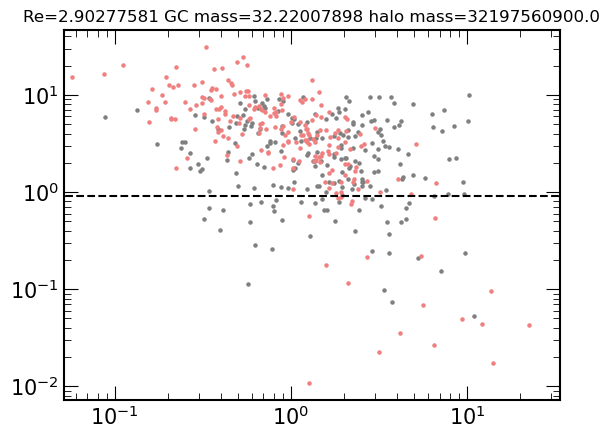

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
2.6520493030548096
3 2.90277581
finished until t = 0.0 0.4015939235687256
finished until t = 0.5 3.7683801651000977
finished until t = 1.0 10.097620487213135
finished until t = 1.5 19.462180376052856
finished until t = 2.0 31.948801279067993
finished until t = 2.5 47.552446365356445
finished until t = 3.0 66.31107974052429
finished until t = 3.5 88.2944130897522
finished until t = 4.0 113.57333159446716
finished until t = 4.5 142.22154235839844
finished until t = 5.0 174.29285383224487
finished until t = 5.5 209.67358565330505
finished until t = 6.0 248.36487436294556
finished until t = 6.5 290.3611972332001
finished until t = 7.0 335.73395228385925
finished until t = 7.5 384.4070086479187
finished until t = 8.0 436.4555444717407
finished until t = 8.5 491.94315099716187
finished until t = 9.0 550.9388823509216
finished until t = 9.5 613.4323801994324
finished until t = 10.0 679.4763088226318


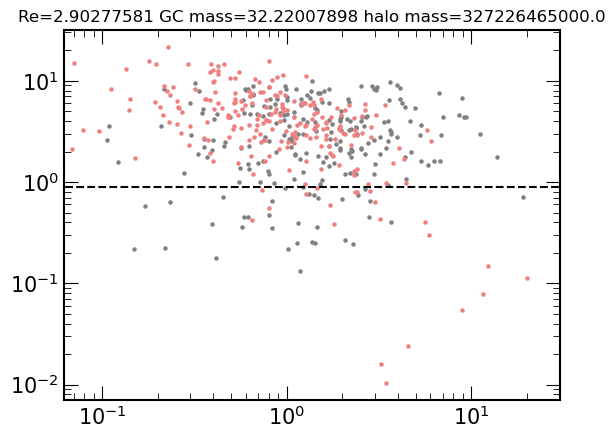

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
2.680718421936035
3 2.90277581
finished until t = 0.0 0.3507063388824463
finished until t = 0.5 3.0636303424835205
finished until t = 1.0 8.2082679271698
finished until t = 1.5 15.817968845367432
finished until t = 2.0 25.933606386184692
finished until t = 2.5 38.65539050102234
finished until t = 3.0 54.04437756538391
finished until t = 3.5 72.17816185951233
finished until t = 4.0 93.11718964576721
finished until t = 4.5 116.94570302963257
finished until t = 5.0 143.74905252456665
finished until t = 5.5 173.5626540184021
finished until t = 6.0 206.36575984954834
finished until t = 6.5 242.1649694442749
finished until t = 7.0 281.03602290153503
finished until t = 7.5 322.95388531684875
finished until t = 8.0 367.9332194328308
finished until t = 8.5 415.99165964126587
finished until t = 9.0 467.15650629997253
finished until t = 9.5 521.38569688797
finished until t = 10.0 578.7150084972382


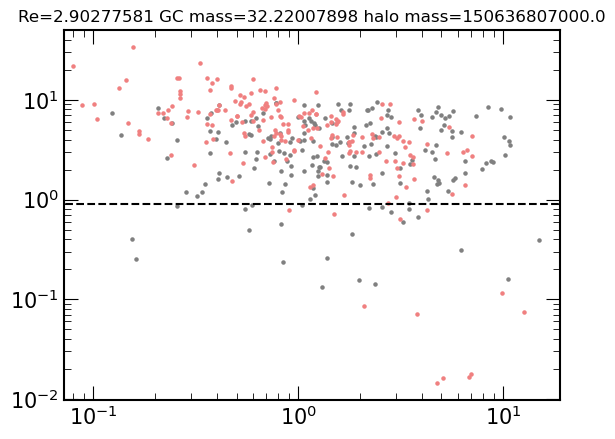

Calculating NFW Energies and Weights


/home/vk9342/.conda/envs/gcfriction/lib/python3.7/site-packages/ipykernel_launcher.py:35: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


Finished calculating NFW Energies and Weights
5.076891899108887
3 2.90277581
finished until t = 0.0 0.33107423782348633
finished until t = 0.5 3.065603494644165
finished until t = 1.0 8.256101131439209
finished until t = 1.5 15.931892395019531
finished until t = 2.0 26.181025505065918
finished until t = 2.5 38.95605826377869
finished until t = 3.0 54.32718515396118
finished until t = 3.5 72.2186667919159
finished until t = 4.0 92.61076164245605
finished until t = 4.5 115.58656477928162
finished until t = 5.0 141.08260369300842
finished until t = 5.5 169.09516716003418
finished until t = 6.0 199.63599276542664
finished until t = 6.5 232.78288221359253
finished until t = 7.0 268.50976943969727
finished until t = 7.5 306.8050949573517
finished until t = 8.0 347.7007555961609
finished until t = 8.5 391.20634603500366
finished until t = 9.0 437.3110828399658
finished until t = 9.5 486.01709938049316
finished until t = 10.0 537.376912355423


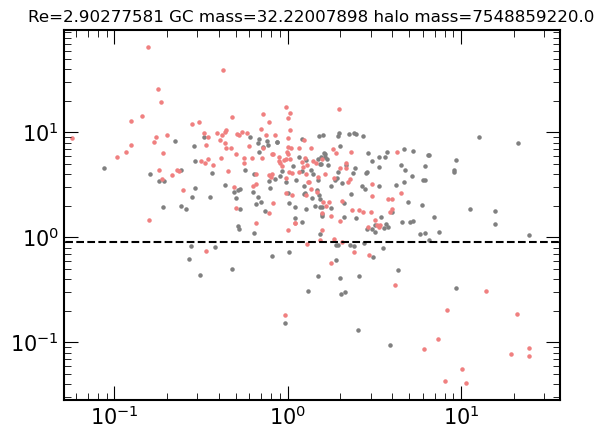

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
3.5730555057525635
3 2.90277581
finished until t = 0.0 0.2624168395996094
finished until t = 0.5 2.082460880279541
finished until t = 1.0 5.479891300201416
finished until t = 1.5 10.507371187210083
finished until t = 2.0 17.214519500732422
finished until t = 2.5 25.62054967880249
finished until t = 3.0 35.72827434539795
finished until t = 3.5 47.56780385971069
finished until t = 4.0 61.12158513069153
finished until t = 4.5 76.36529493331909
finished until t = 5.0 93.36808490753174
finished until t = 5.5 112.0849187374115
finished until t = 6.0 132.53391885757446
finished until t = 6.5 154.72024512290955
finished until t = 7.0 178.7016475200653
finished until t = 7.5 204.51491689682007
finished until t = 8.0 232.1374876499176
finished until t = 8.5 261.6615765094757
finished until t = 9.0 293.093701839447
finished until t = 9.5 326.45574855804443


In [ ]:
#NFW

#iterate over every combination of params
for R_e, GC_mass, halo_mass in itertools.product(R_es, GC_masses, halo_masses):
    rho0 = rho_0_func(halo_mass)
    r0 = r_0_func(halo_mass)

    R_e_rounded = round(R_e, 3)
    GC_mass_rounded = round(GC_mass, 3)
    halo_mass_rounded = round(halo_mass, 1)
    rho0_rounded = round(rho0, 2)
    r0_rounded = round(r0, 2)

    file_name = 'Sim_'+'NFW_20'+'_'+str(R_e_rounded)+'_'+str(GC_mass_rounded)+'_'+str(halo_mass_rounded)+'.txt'
    file_path = '/home/vk9342/spring2024research/test_sim_run_1/'+str(file_name)
    if not os.path.exists(file_path):
    
        ## a C implementation of friction and background forces in rebound, for speed
        clib_additional_forces = cdll.LoadLibrary("/home/vk9342/spring2024research/additional_forces_rho0"+str(rho0_rounded)+'_r0'+str(r0_rounded) +".so")
        
        # NFW ergodic distribution function, calling helpers from NFW_profile_functions.py
        ######################################
        # MAKE SURE THESE rho0 and r0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
        ######################################
    
        G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
        Sersic_params_NFW = [R_e, n]
        @np.vectorize
        def NFW_ergodic_f(E):
            def integrand(psi):
                def r_psi(psi):
                    rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho0, r0))  #lambda (def short function) arguments : expression
                    return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
                return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho0, r0, Sersic_params_NFW[0], Sersic_params_NFW[1])
            return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]
    
        start = time.time()
        print('Calculating NFW Energies and Weights')
        energy_values_NFW = 4 * np.pi * G * rho0 * r0**2 * np.arange(-1+0.005, -0.005, 0.005)
        energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
        #E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
        print('Finished calculating NFW Energies and Weights')
        print(time.time()-start)
        print(n, R_e)
    
        #making interpolated functions for f(E) that can be called in the initialization process for speed
    
        def NFW_f_interp(E):
            return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))
    
    
        #################################
        ## SAVES OUTPUTS FOR EVERY 0.5 Gyr
        def run_sim(potential, force, halo_params, ergodic_f, seed, t):
            start = time.time()
            np.random.seed(seed)
    
            # usual initialization of the sim, units, etc.
            sim = rebound.Simulation()
            sim.ri_ias15.epsilon = 0 # using fixed timesteps
            #sim.ri_ias15.min_dt = 1e-5
            #sim.ri_ias15.max_dt = 1e-3
            sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
            sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
            sim.softening = 0.01 # plummer softening of 10 pc
            sim.collision = "line" # counting collisions as linear interpolations between timesteps
            sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers
    
            # Sersic radial distribution and values to draw positions with their weights
    
            pos_values = np.arange(1e-4, 10, 1e-4)
            pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
            pos_weights /= sum(pos_weights)
    
    
            # setting up a mass function gaussian in logM
            logmass_values = np.linspace(-2, 2, 1000)
            logmass_weights = mass_function(logmass_values)
            logmass_weights /= sum(logmass_weights)
    
            total_GC_mass = 0
            # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
            while total_GC_mass < GC_mass-10**(4.987311450993631 - 5):
                mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
                pos_rad = np.random.choice(pos_values, p=pos_weights)
                pos_theta = np.random.uniform(0, np.pi)
                pos_phi = np.random.uniform(0, 2*np.pi)
                x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
                y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
                z_i = pos_rad*np.cos(pos_theta)
    
                # drawing velocities from provided distribution
                vel_values = np.arange(0.01, 100, 0.01)
                vel_weights = 4*np.pi*vel_values**2 * \
                                ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho0, r0))/(nu(pos_rad, R_e, n))
                vel_weights /= sum(vel_weights)
                vel_mag = np.random.choice(vel_values, p=vel_weights)
                v_theta = np.random.uniform(0, np.pi)
                v_phi = np.random.uniform(0, 2*np.pi)
                vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
                vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
                vz_i = vel_mag * np.cos(v_theta)
    
                sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                        x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
                total_GC_mass += mass/np.exp(10/23)
    
            rebx = reboundx.Extras(sim)
            # adding in the additional forces to work with reboundx
            myforce = rebx.create_force("additional_forces_rho0"+str(rho0_rounded)+'_r0'+str(r0_rounded))
            myforce.force_type = "vel"
            myforce.update_accelerations = force
            rebx.add_force(myforce)
            # setting up built-in exponential mass loss
            modifymass = rebx.load_operator("modify_mass")
            rebx.add_operator(modifymass)
            # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
            for p in sim.particles:
                p.params["tau_mass"] = -23
    
            # keeping track of initial positions, velocities, and masses
            initial_masses = []
            initial_positions = []
            initial_vels = []
    
            for p in sim.particles:
                initial_masses.append(p.m)
                initial_positions.append(np.array([p.x, p.y, p.z]))
                initial_vels.append(np.array([p.vx, p.vy, p.vz]))
    
            # integrating
            sim.integrate(t)
    
            # keeping track of final positions, velocities, and masses
            final_masses = []
            final_positions = []
            final_vels = []
    
            for p in sim.particles:
                final_masses.append(p.m)
                final_positions.append(np.array([p.x, p.y, p.z]))
                final_vels.append(np.array([p.vx, p.vy, p.vz]))
    
            initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
            initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
            initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)
    
            # clearing sim from memory now that we've stored everything important
            sim = None
    
            # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
            return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]
    
        ###############################################################################
        ## run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs
    
        def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
            seeds = np.random.randint(1, 4294967295, size = N_iterations)
    
            start = time.time()
    
            for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):
    
                if output_time == 0:
                    # save initial data
                    f = open('Sim_'+output_name+'_'+str(output_time)+'_'+str(R_e_rounded)+'_'+str(GC_mass_rounded)+'_'+str(halo_mass_rounded)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=0.001)
                        for GC_n in range(len(masses[0])):
                            f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                                    +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                                    +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                                    +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                else:
                    # save final data
                    f = open('Sim_' +output_name+'_'+str(output_time)+'_'+str(R_e_rounded)+'_'+str(GC_mass_rounded)+'_'+str(halo_mass_rounded)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=t)
                        for GC_n in range(len(masses[1])):
                            f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                        +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                        +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                        +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                print('finished until t = '+str(t), str(time.time()-start))
    
        ##############################################
        #RUNS EVERYTHING 
        
        run_iterations(10, 'NFW', phi_NFW, clib_additional_forces.NFW_DF_Petts, [17.99, 25.34], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_'+'NFW_0'+'_'+str(R_e_rounded)+'_'+str(GC_mass_rounded)+'_'+str(halo_mass_rounded)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_'+'NFW_20'+'_'+str(R_e_rounded)+'_'+str(GC_mass_rounded)+'_'+str(halo_mass_rounded)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
    
        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        #plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' GC mass='+str(GC_mass)+' halo mass='+str(halo_mass))
        # plt.savefig('NFW-3_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()


    # else:
    #     print('File already exists')


In [5]:
def halo_mass_calc (M_star):
    alpha = 1.74
    M1 = 10**(12.5) #solar masses
    log_epsilon = -1.70
    M = M1 * 10**(1/alpha * (np.log10(M_star/M1) - log_epsilon))
    return M

M200 = halo_mass_calc(1.72 * 10**8)
print(M200/10**10)
h = 0.7
c = 5

M_star1 = 1.63 * 10**7
M_star2 = 1.72 * 10**8
M_star3 = 1.73 * 10**9


rho_crit = 0.00136 # critical density with h = 0.7 in units of 10^5/kpc^3
# NFW scale radius from M200 and c
r0_N = 1/c * (3*(M200/10**5)/(4*np.pi*200*rho_crit))**(1/3)
# NFW scale density from c
rho0_N = rho_crit * 200/3 * (c**3 / (np.log(1+c) - c/(1+c)))

print (r0_N, rho0_N)

40.024447594138785
30.403198390950834 11.824941859242292


In [ ]:
rho value (11.82) r0 19.54